<center> <h3> Spotify Data Engineering & Machine Learning Take-home Challenge </h3> </center> 
<center> <h3> By: Jeevan Vankayala </h3> </center> 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time

In [2]:
user_data = pd.read_csv('data_sample/user_data_sample.csv')
song_data = pd.read_csv('data_sample/end_song_sample.csv')

In [3]:
song_user_merge = pd.merge(user_data,song_data,on='user_id')
gender_stats = song_user_merge.groupby('gender').aggregate({'gender':'size','track_id':lambda x: len(x.unique()),'ms_played':lambda x: sum(x)/60000})
gender_stats=gender_stats.head(2).rename(columns={'track_id':'Tracks Listened','gender':'Total Users','ms_played':'Minutes Streamed'})

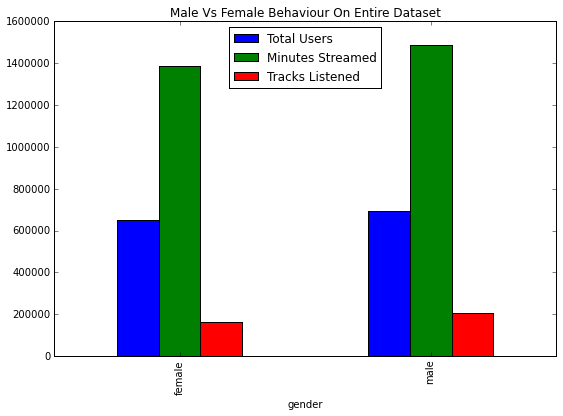

In [4]:
gender_stats.plot(kind='bar',figsize=(9, 6),title="Male Vs Female Behaviour On Entire Dataset")

### Male vs Female Comparision

From the above graph, we can clearly infer that there is no significant difference between **Male** and **Female** listeners in their over all listening habits. I plotted the graph in terms of
1. Total Male and Female users
2. Unique tracks listened 
3. Total streaming time in minutes.

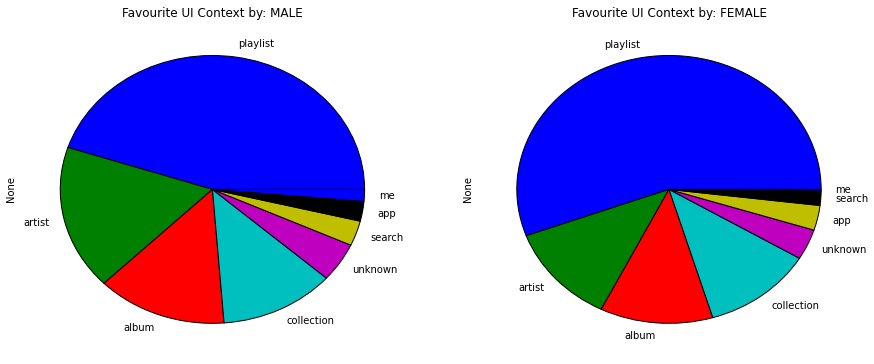

In [5]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 6))
var = ['male','female']
for ind,gend in enumerate(var):
    song_user_merge[song_user_merge['gender']==gend].groupby(['context']).size().sort_values(ascending=False).\
    plot(kind='pie',ax=axs[ind],title='Favourite UI Context by: '+gend.upper())

### Favourite UI context by Gender

From the above, the listening habits for both *Male* and *Female* are similar.The top UI context users liked to play the track is from **Playlist** and their next best destination includes **Artist/Albums** 

In [6]:
def get_session(x):
    local_tm_hr = time.localtime(x).tm_hour
    if 0 < local_tm_hr <= 6:
        return 'Mid Night'
    elif 6 < local_tm_hr <= 12:
        return 'Morning'
    elif 12 < local_tm_hr <= 18:
        return 'Noon'
    else:
        return 'Evening'

### Dividing user activity in terms of sessions

The above function divides the user listening in to sessions based on *end_timestamp* 

Session Name|Time Hour
---|---
Mid Night|0:00 - 6:00
Morning|7:00 - 12:00
Noon|13:00 - 18:00
Evening|19:00 - 24:00

In [7]:
songs_sorted = song_user_merge.sort_values(['user_id','end_timestamp'])
songs_sorted['session'] = songs_sorted['end_timestamp'].apply(get_session)
session_age = songs_sorted.groupby(['session','age_range']).size()
session_age_top = session_age.sort_values(ascending=False).head(10)
session_avg = songs_sorted.groupby(['session'])['ms_played'].agg({'avg':lambda x: np.mean(x)/60000,'total':lambda x: np.sum(x)/3600000})

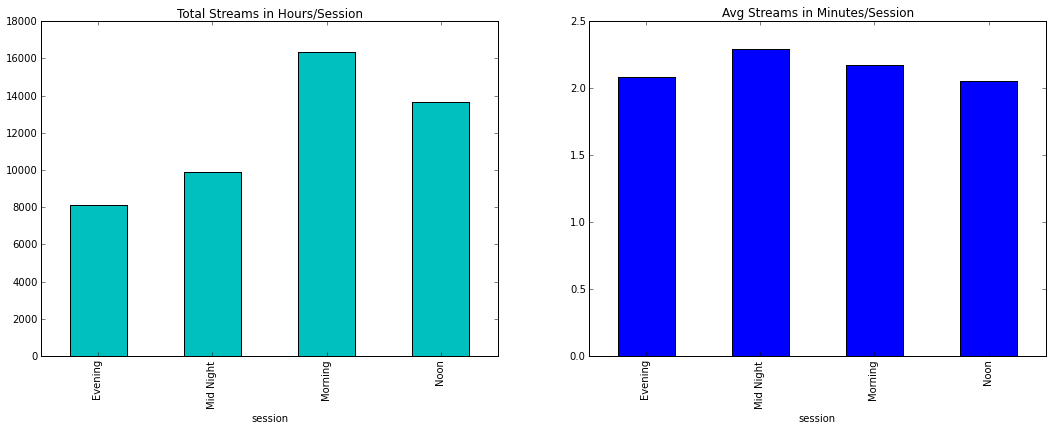

In [8]:
fig, axs = plt.subplots(ncols=2,figsize=(18,6))
session_avg['total'].plot(kind='bar',title='Total Streams in Hours/Session',ax=axs[0],color='c')
session_avg['avg'].plot(kind='bar',title='Avg Streams in Minutes/Session',ax=axs[1])

### Activity breakdown by Session

An interesting observation found from above plots
1. Most of the users stream more music during **Morning** when compared to other parts of the day. 
2. Even though most of the users stream during mornings, their average session stream length is high during **Mid Nights**

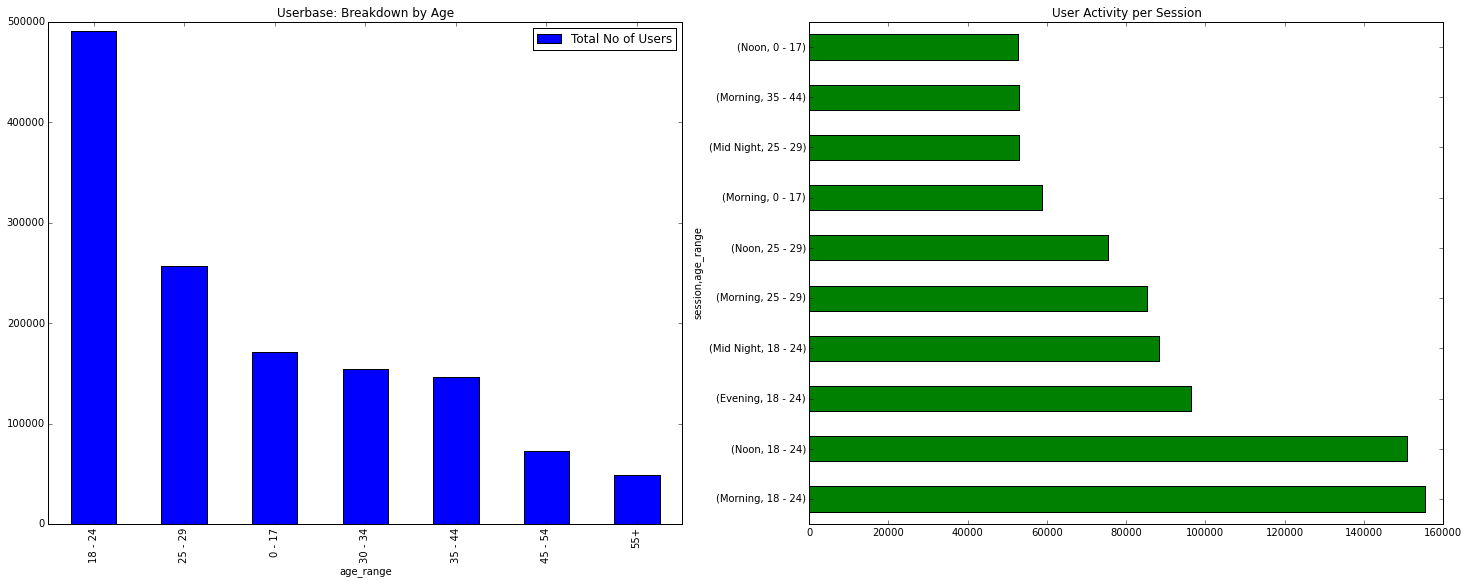

In [9]:
fig, axs = plt.subplots(ncols=2,figsize=(25,9))
song_user_merge.groupby('age_range')['age_range'].agg({'Total No of Users':np.size}).sort_values('Total No of Users',ascending=False).\
plot(kind='bar',ax=axs[0],title="Userbase: Breakdown by Age")
session_age_top.plot(kind='barh',color=['g'],legend=False,ax=axs[1],title="User Activity per Session")

### Activity breakdown by Age

From above plots we can tell that
1. People from age group **18-24** are the highest number of registered users in Spotify. 
2. Age group **18-24** are the most dominating group listening in every session. **Morning** being the most active session.

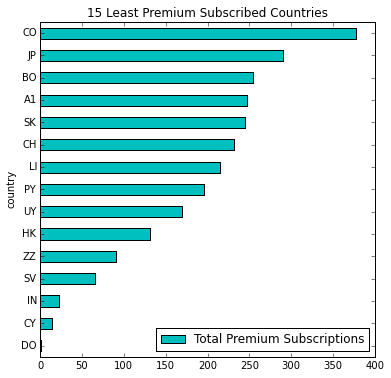

In [10]:
x=songs_sorted.groupby(['country','product']).size().reset_index()
x[x['product']=='premium'].rename(columns={0:'Total Premium Subscriptions'}).sort_values('Total Premium Subscriptions',ascending=True).\
set_index(['country']).head(15).plot(kind='barh',figsize=(6,6),title="15 Least Premium Subscribed Countries",color='c')

### Least premium subscribed countries

From the given data, the above plot shows 15 least premium subscibed users. This helps us to launch promotional campaigns across those countries to increase 
premium subscriptions.

### Dividing Users into Clusters

In order to divide users into clusters, I thought of dividing users who are 
1. Premium or who started free, but turned into premium as **Premium Users** cluster 
2. Free and remained free till the end into **Free Users** cluster

Below, I divided the dataset into above discussed cluster by creating *is_perm* column where a user used premium product atleast once in the dataset

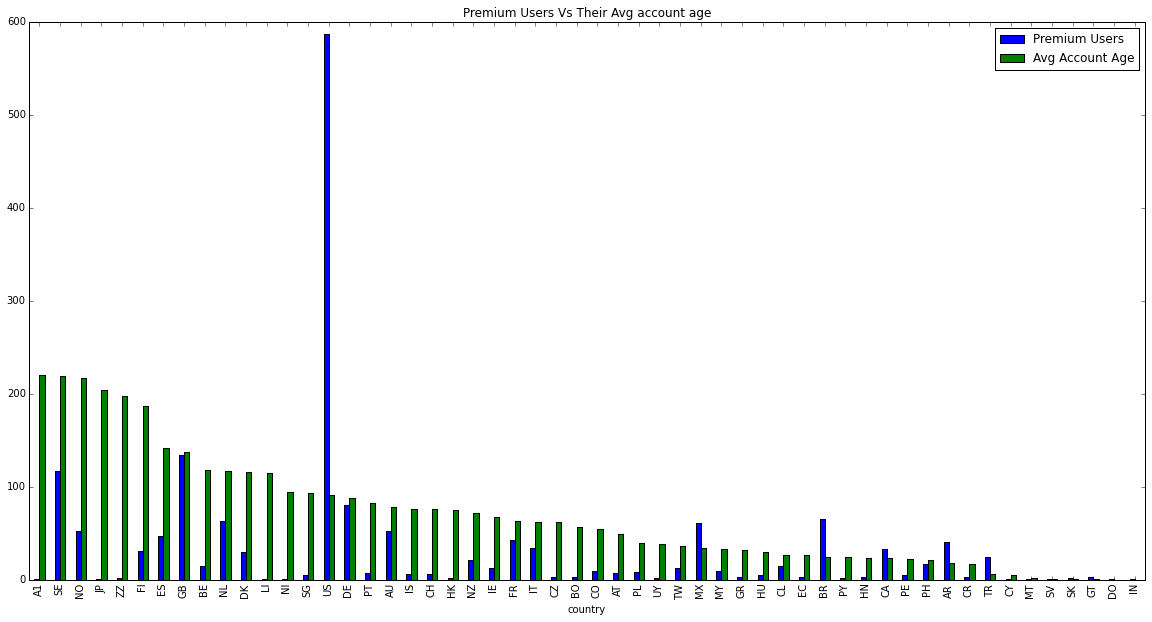

In [11]:
g=songs_sorted.groupby(['user_id','country','age_range','acct_age_weeks'])
gg=g.aggregate({'product':lambda x: list(set(x))})
gg['is_prem'] = gg['product'].apply(lambda x: x.__contains__('premium'))
gg[gg['is_prem'] == True].reset_index().groupby('country').aggregate({'country':'count','acct_age_weeks':np.mean}).\
sort_values(['acct_age_weeks'],ascending=False).rename(columns={'country':'Premium Users','acct_age_weeks':'Avg Account Age'}).\
plot(kind='bar',figsize=(20,10),title='Premium Users Vs Their Avg account age')

### Insights from **Premium Users Cluster**

The above plot shows ***Premium Users Vs Their Avg account age for a country*** i.e Number of Spotify users who turned into premium in a country and their average account age in weeks. The above graph shows some interesting results such as
1. **US** contains the highest premium users and their average account age when they turned premium is around 100 weeks
2. **GB** is the next country to have more premium users. Surprisingly they are taking longer time to convert into premium
3. **MX** and **BR** are countries that are converting into premium quickly when compared to other countries and their account age.

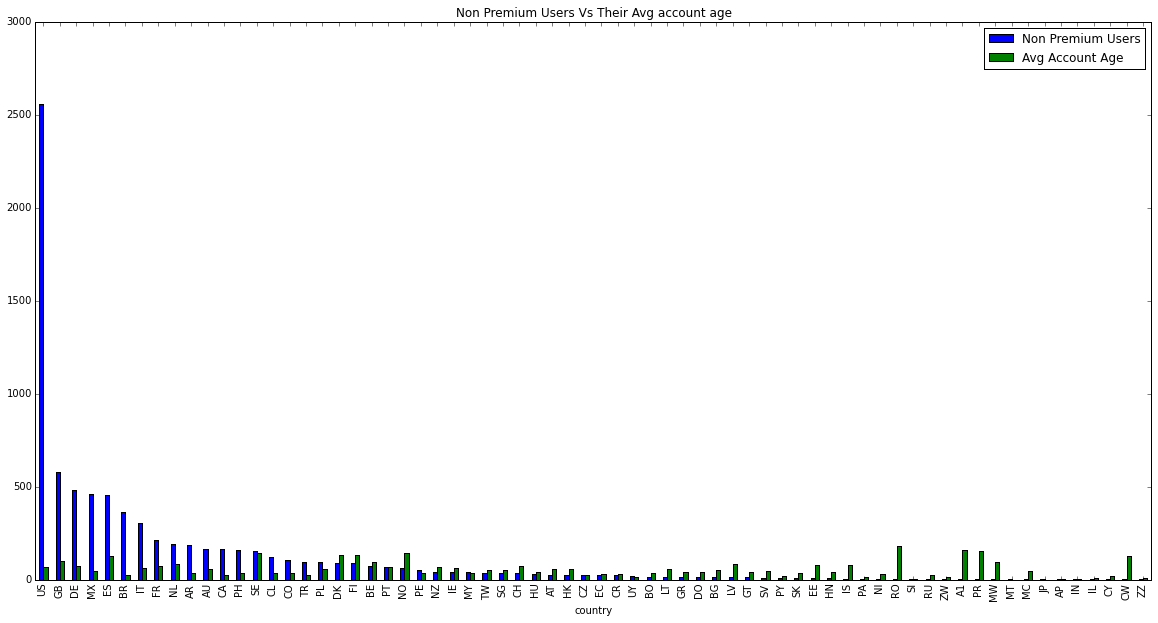

In [12]:
gg[gg['is_prem'] == False].reset_index().groupby('country').aggregate({'country':'count','acct_age_weeks':np.mean}).\
sort_values(['country'],ascending=False).rename(columns={'country':'Non Premium Users','acct_age_weeks':'Avg Account Age'}).\
plot(kind='bar',figsize=(20,10),title='Non Premium Users Vs Their Avg account age')

### Insights from **Free Users Cluster**

The above plot shows ***Free Users Vs Their Avg account age for a country*** i.e Number of Spotify users who remained free in a country and did not turn into premium as of the last date in the dataset and their average account age in weeks. The above graph shows some interesting results such as
1. **US, GB** has lot of users who are using free, and has lot of scope turning them into potential premium users. 
2. **MX, BR** are the country that are young in terms of their account age and have lot of free users. These countires are rapidly improving in their premium subscriptions and Spotify should really focus on these countries as they are disruptive.
3. **NO, RO, A1, PR, CW** are countries that has some very old users who's average account age is high but some how their conversion rates are very low. Spotify should really focus on such countries by introducing campaigns and grab their market. 

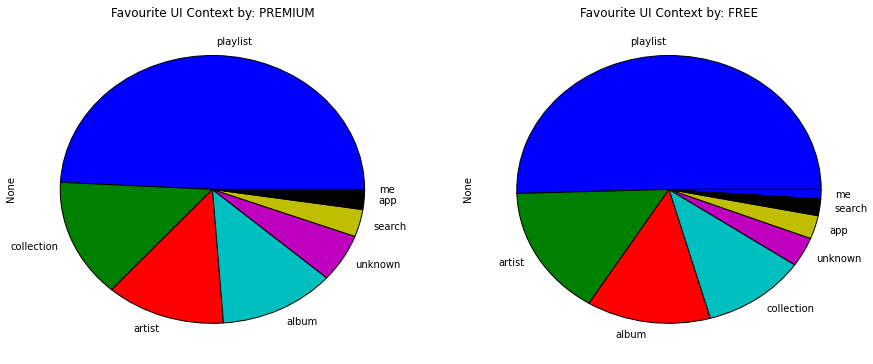

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 6))
song_user_merge[song_user_merge['product']=='premium'].groupby(['context']).size().sort_values(ascending=False).\
    plot(kind='pie',ax=axs[0],title='Favourite UI Context by: '+'premium'.upper())
song_user_merge[song_user_merge['product']!='premium'].groupby(['context']).size().sort_values(ascending=False).\
    plot(kind='pie',ax=axs[1],title='Favourite UI Context by: '+'Free'.upper())

###  Premium Vs Free Users UI Context 

The above plot shows ***Premium vs Free users UI context*** 
1. The top UI context is **Playlist** for both Premium and Free users.
2. Interestingly **Collection** is the next favourite for Premium users and **Artist** is the next favourite for Free users